In [ ]:

!pip install torchviz



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=0a0dd6b029720845eb12e62ab5c3d963e528a32460d882700af2b63c2254bf86
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
# Importing necessary libraries for image processing
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

# For text preprocessing and word embeddings
import spacy
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# For visualization
from torchviz import make_dot

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# For saving and loading models
import torch
import os

# For handling device (GPU/CPU) configurations
import torch.cuda

# If needed, for tqdm progress bars during training
from tqdm import tqdm

# For other utilities
import random
import string
import time

# For handling file I/O
import shutil


In [ ]:
import numpy as np
import gensim

# Path to the GloVe file
glove_file_path = "/content/drive/MyDrive/glove.6B.50d.txt"

# Function to load GloVe embeddings
def load_glove_model(glove_file_path):
    print("Loading GloVe model...")
    model = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            model[word] = vector
    print(f"Loaded {len(model)} word vectors.")
    return model

# Load the GloVe model
glove_model = load_glove_model(glove_file_path)


Loading GloVe model...
Loaded 400000 word vectors.


In [ ]:
import spacy

# Load spaCy English tokenizer
nlp = spacy.load("en_core_web_sm")

# Function to preprocess the text
def preprocess_text(text):
    # Tokenize and lemmatize the text, removing stopwords and punctuation
    doc = nlp(text)
    processed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return processed_tokens



**EMBEDDINGS**

In [ ]:
# Function to convert text to GloVe embeddings
def text_to_glove_vector(text, glove_model):
    tokens = preprocess_text(text)
    vector = np.zeros(50)  # Size of GloVe vectors (50D in this case)
    valid_tokens = 0

    # Sum the word vectors for each word in the processed text
    for token in tokens:
        if token in glove_model:
            vector += glove_model[token]
            valid_tokens += 1

    # If there are valid tokens, return the average; otherwise, return zero vector
    if valid_tokens > 0:
        vector /= valid_tokens
    return vector



In [ ]:
import pandas as pd
import json

# Load the JSONL file
def load_jsonl(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    return data

# Load the train.jsonl file (adjust path as needed)
train_data = load_jsonl('/content/drive/MyDrive/data/train.jsonl')

# Preview the data structure
print(train_data[0])  # print the first entry to understand the structure

# Extracting the image path, text, and label
image_paths = [entry['img'] for entry in train_data]
texts = [entry['text'] for entry in train_data]
labels = [entry['label'] for entry in train_data]  # Assuming the label is in the 'label' field


{'id': 42953, 'img': 'img/42953.png', 'label': 0, 'text': 'its their character not their color that matters'}


In [ ]:
import spacy

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function to preprocess text
def preprocess_text(text):
    doc = nlp(text)
    # Lemmatizing and removing punctuation or spaces
    processed_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    return " ".join(processed_tokens)

# Apply preprocessing to the text data
processed_texts = [preprocess_text(text) for text in texts]


**Load and Preprocess the Images:**


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from concurrent.futures import ThreadPoolExecutor

# Define image directory path (adjust it to your actual image directory)
image_directory = "/content/drive/MyDrive/data/img"  # Modify as needed

# Get list of image paths in the directory
image_paths = [os.path.join(image_directory, fname) for fname in os.listdir(image_directory) if fname.endswith('.png')]

# Function to load and preprocess an image
def preprocess_image(img_path, target_size=(224, 224)):
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")  # Debugging if the file is not found
        return None  # Return None if image file doesn't exist
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Parallelize the image processing with ThreadPoolExecutor
def process_images_parallel(image_paths, num_workers=4):
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        image_data = list(executor.map(preprocess_image, image_paths))
    # Filter out None values
    return [img for img in image_data if img is not None]

# Process the images in parallel (use more workers if needed)
image_data = process_images_parallel(image_paths, num_workers=4)

# Now `image_data` contains all the preprocessed images (images that exist and are successfully loaded)
print(f"Processed {len(image_data)} images.")


Processed 9260 images.


**Obtain GloVe Embeddings for the Text:**

In [ ]:
import numpy as np
import spacy

# Load GloVe embeddings (assuming you have the glove.6B.50d.txt file already)
glove_file = '/content/drive/MyDrive/glove.6B.50d.txt'  # Path to your GloVe file
glove_embeddings = {}

# Load GloVe into a dictionary
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print("Loaded GloVe embeddings.")

# Load Spacy model for text preprocessing
nlp = spacy.load("en_core_web_sm")

# Function to preprocess and convert text to GloVe vector
def text_to_glove_vector(text, glove_embeddings, model=nlp):
    # Tokenize and preprocess the text (lemmatization, removing stop words, punctuation)
    doc = model(text)
    vectors = []

    for token in doc:
        if token.text in glove_embeddings:  # Check if word is in GloVe
            vectors.append(glove_embeddings[token.text])

    if len(vectors) == 0:
        return np.zeros(50)  # Return a zero vector if no words match in GloVe

    # Average the vectors to create a single vector representation of the text
    return np.mean(vectors, axis=0)

# Example usage
texts = ["This is an example caption.", "Another example caption for meme."]
glove_vectors = []

for text in texts:
    glove_vectors.append(text_to_glove_vector(text, glove_embeddings))

# Now `glove_vectors` contains the 50-dimensional GloVe vectors for each text in `texts`
print("GloVe vectors obtained for texts.")


Loaded GloVe embeddings.
GloVe vectors obtained for texts.


In [ ]:
# Function to convert preprocessed text to its GloVe embedding vector
def text_to_glove_vector(text, glove_model, embedding_dim=50):
    tokens = text.split()  # Split text into words (since it's already lemmatized)
    vector = np.zeros(embedding_dim)  # Initialize the vector with zeros

    valid_tokens = 0  # To track how many valid tokens we have
    for token in tokens:
        if token in glove_model:
            vector += glove_model[token]
            valid_tokens += 1

    if valid_tokens > 0:
        vector /= valid_tokens  # Average the vectors of all valid tokens

    return vector

# Now obtain the GloVe vectors for all the preprocessed texts
glove_vectors = []
for text in processed_texts:
    glove_vectors.append(text_to_glove_vector(text, glove_embeddings))

print("GloVe vectors obtained for all preprocessed texts.")


GloVe vectors obtained for all preprocessed texts.


In [ ]:
import numpy as np
from tensorflow.keras import layers, models

# Convert image_data (list) to a NumPy array
image_data_np = np.array(image_data)

# Flatten the image data
image_data_flat = image_data_np.reshape(image_data_np.shape[0], -1)  # Flatten the image data

# Convert glove_vectors to a NumPy array
glove_vectors_np = np.array(glove_vectors)

# Input layer for image data (Flattened images)
image_input = layers.Input(shape=(image_data_flat.shape[1],))  # Flattened image data

# Input layer for text data (GloVe embeddings)
text_input = layers.Input(shape=(glove_vectors_np.shape[1],))  # GloVe vector for text

# Concatenate image and text data (Early Fusion)
combined_input = layers.concatenate([image_input, text_input])

# Fully connected layers after fusion
x = layers.Dense(512, activation='relu')(combined_input)
x = layers.Dense(256, activation='relu')(x)

# Final output layer
output = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model_early = models.Model(inputs=[image_input, text_input], outputs=output)

# Compile the model
model_early.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_early.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150528)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 150578)               0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 512)                  7709644   ['concatenate[0][0]']     

In [ ]:
import pandas as pd

# Load the training data
df_train = pd.read_json('/content/drive/MyDrive/data/train.jsonl', lines=True)

# Load the test data
df_test = pd.read_json('/content/drive/MyDrive/data/test.jsonl', lines=True)

# Check the first few rows of the dataset
print(df_train.head())
print(df_test.head())


      id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolate chip cookies, even h...  
      id            img                                         text
0  16395  img/16395.png                     handjobs sold seperately
1  37405  img/37405.png         introducing fidget spinner for women
2  94180  img/94180.png  happy pride month let's go beat up lesbians
3  54321  img/54321.png       laughs in [majority of u.s crime rate]
4  97015  img/97015.png       finds out those 72 virgins.. are goats


In [ ]:
# Extract labels for training
y_train = df_train['label'].values

# Extract image paths and text for training
image_paths_train = df_train['img'].values
texts_train = df_train['text'].values

# Check if the label extraction works
print(f"Labels: {y_train[:5]}")


Labels: [0 0 0 0 0]


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert the lists to NumPy arrays
image_data = np.array(image_data[:8500])  # Make sure the number of images matches the glove_vectors
glove_vectors = np.array(glove_vectors[:8500])  # Similarly, reduce glove_vectors if needed
valid_labels = np.array(valid_labels[:8500])  # Ensure valid_labels matches the image and glove_vectors length

# Now split the data
X_images_train, X_images_test, X_glove_train, X_glove_test, y_train, y_test = train_test_split(
    image_data, glove_vectors, valid_labels, test_size=0.2, random_state=42)

# Check the shapes of the split data
print(f"Training image data shape: {X_images_train.shape}")
print(f"Test image data shape: {X_images_test.shape}")
print(f"Training GloVe vectors shape: {X_glove_train.shape}")
print(f"Test GloVe vectors shape: {X_glove_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Training image data shape: (6800, 224, 224, 3)
Test image data shape: (1700, 224, 224, 3)
Training GloVe vectors shape: (6800, 50)
Test GloVe vectors shape: (1700, 50)
Training labels shape: (6800,)
Test labels shape: (1700,)


**TEXT MODEL**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Text preprocessing
vocab_size = 10000  # Assuming a vocabulary size
embedding_dim = 128
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
# Fit tokenizer on your text data and convert to sequences
# tokenizer.fit_on_texts(text_data) # Example text data
# sequences = tokenizer.texts_to_sequences(text_data)
# padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Text model definition
text_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the text model
# text_model.fit(padded_sequences, labels, epochs=10, validation_data=(val_padded_sequences, val_labels))


**IMAGE MODEL**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

image_model = Model(inputs=base_model.input, outputs=output)

image_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the image model
# Use ImageDataGenerator for image preprocessing if needed
# image_model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


**EARLY FUSION**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define image input layer
image_input = layers.Input(shape=(224, 224, 3))  # Image input shape

# Define a simple CNN for image feature extraction
x_image = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x_image = layers.MaxPooling2D((2, 2))(x_image)
x_image = layers.Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = layers.MaxPooling2D((2, 2))(x_image)
x_image = layers.Flatten()(x_image)

# Define text input layer (GloVe vectors)
text_input = layers.Input(shape=(50,))  # GloVe vector size (50)

# Early fusion: concatenate image features and text features
combined = layers.concatenate([x_image, text_input])

# Add fully connected layers after fusion
x = layers.Dense(512, activation='relu')(combined)
x = layers.Dense(256, activation='relu')(x)

# Final output layer (binary classification)
output = layers.Dense(1, activation='sigmoid')(x)

# Create and compile the model
model = models.Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    [X_images_train, X_glove_train],  # Input: images and GloVe vectors
    y_train,  # Output: labels
    validation_data=([X_images_test, X_glove_test], y_test),
    epochs=10,  # Set number of epochs as needed
    batch_size=32  # Set batch size as needed
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate([X_images_test, X_glove_test], y_test)
print(f"Test accuracy: {test_acc}")


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 222, 222, 32)         896       ['input_9[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d_6[0][0]'

HYBRID FUSION

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Image model branch
def create_image_model(input_shape):
    image_input = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return models.Model(image_input, x)

# Text model branch
def create_text_model(input_shape):
    text_input = Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(text_input)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(text_input, x)

# Combine image and text models (Middle Fusion)
image_shape = (224, 224, 3)  # Adjust for your image input size
text_shape = (50,)  # Adjust for your GloVe vector size

image_model = create_image_model(image_shape)
text_model = create_text_model(text_shape)

# The middle fusion step: Flatten and concatenate features before the dense layers
image_features = layers.Flatten()(image_model.output)
text_features = layers.Flatten()(text_model.output)

# Combine features from both image and text at the "middle" stage
combined_features = layers.concatenate([image_features, text_features])

# Further fully connected layers
x = layers.Dense(128, activation='relu')(combined_features)
x = layers.Dense(64, activation='relu')(x)

# Final output layer
output = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Define the final model
model = models.Model(inputs=[image_model.input, text_model.input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(
    [X_images_train, X_glove_train], y_train,
    validation_data=([X_images_test, X_glove_test], y_test),
    epochs=10,
    batch_size=32
)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 222, 222, 32)         896       ['input_11[0][0]']            
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 109, 109, 64)         18496     ['max_pooling2d_8[0][0]'

**LATE FUSION**

In [ ]:
# Image model branch
image_input = Input(shape=image_shape)
x_image = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x_image = layers.MaxPooling2D((2, 2))(x_image)
x_image = layers.Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = layers.MaxPooling2D((2, 2))(x_image)
x_image = layers.Conv2D(128, (3, 3), activation='relu')(x_image)
x_image = layers.GlobalAveragePooling2D()(x_image)

# Text model branch
text_input = Input(shape=text_shape)
x_text = layers.Dense(128, activation='relu')(text_input)
x_text = layers.Dense(64, activation='relu')(x_text)

# Combine image and text outputs at the final stage
combined_output = layers.concatenate([x_image, x_text])
x = layers.Dense(64, activation='relu')(combined_output)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the final model
late_fusion_model = models.Model(inputs=[image_input, text_input], outputs=output)

# Compile the model
late_fusion_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = late_fusion_model.fit(
    [X_images_train, X_glove_train], y_train,
    validation_data=([X_images_test, X_glove_test], y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
213/213 [==============================] - 84s 389ms/step - loss: 0.6366 - accuracy: 0.6499 - val_loss: 0.6197 - val_accuracy: 0.6671
Epoch 2/10
213/213 [==============================] - 81s 379ms/step - loss: 0.6225 - accuracy: 0.6638 - val_loss: 0.6155 - val_accuracy: 0.6788
Epoch 3/10
213/213 [==============================] - 81s 382ms/step - loss: 0.6099 - accuracy: 0.6756 - val_loss: 0.6121 - val_accuracy: 0.6729
Epoch 4/10
213/213 [==============================] - 82s 384ms/step - loss: 0.6051 - accuracy: 0.6766 - val_loss: 0.6092 - val_accuracy: 0.6700
Epoch 5/10
213/213 [==============================] - 81s 382ms/step - loss: 0.5974 - accuracy: 0.6846 - val_loss: 0.6078 - val_accuracy: 0.6724
Epoch 6/10
213/213 [==============================] - 81s 383ms/step - loss: 0.5916 - accuracy: 0.6854 - val_loss: 0.6055 - val_accuracy: 0.6788
Epoch 7/10
213/213 [==============================] - 81s 381ms/step - loss: 0.5872 - accuracy: 0.6890 - val_loss: 0.6134 - val_ac

**EVALUATIONS**

In [ ]:
# Assuming the image model expects flattened input:
def flatten_image_input(X_images):
    # Flatten the image input to match the shape expected by the model
    return X_images.reshape(X_images.shape[0], -1)

# Flatten the test images before passing them to the model
X_images_test_flattened = flatten_image_input(X_images_test)

# Now make predictions with the flattened images
early_fusion_predictions = model_early.predict([X_images_test_flattened, X_glove_test])
early_fusion_predictions = (early_fusion_predictions > 0.5).astype(int)


54/54 [==============================] - 1s 12ms/step


In [ ]:
# Assuming the image model expects flattened input:
def flatten_image_input(X_images):
    # Flatten the image input to match the shape expected by the model
    return X_images.reshape(X_images.shape[0], -1)

# Flatten the test images before passing them to the model
X_images_test_flattened = flatten_image_input(X_images_test)

# Now make predictions with the flattened images
early_fusion_predictions = model_early.predict([X_images_test_flattened, X_glove_test])
early_fusion_predictions = (early_fusion_predictions > 0.5).astype(int)


54/54 [==============================] - 1s 12ms/step


54/54 [==============================] - 5s 87ms/step
Accuracy: 0.6724
Precision: 0.6090
Recall: 0.3040
F1 Score: 0.4055
Confusion Matrix:
[[953 122]
 [435 190]]


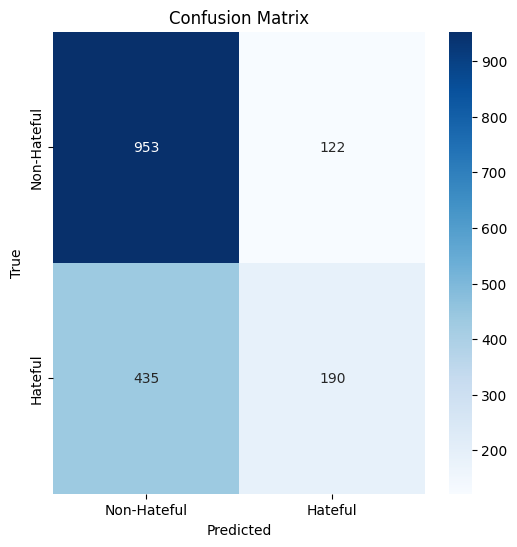

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the predictions and ground truth
# Replace with your actual test data
y_pred = model.predict([X_images_test, X_glove_test])
y_pred = (y_pred > 0.5).astype(int)  # If it's a binary classification problem

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hateful', 'Hateful'], yticklabels=['Non-Hateful', 'Hateful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Saving the model
model.save('multimodal_fusion_model.h5')  # Save the entire model (architecture + weights + optimizer)

# To load the model later
from tensorflow.keras.models import load_model
saved_model = load_model('multimodal_fusion_model.h5')

# Check if the model is loaded correctly
saved_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 222, 222, 32)         896       ['input_11[0][0]']            
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 109, 109, 64)         18496     ['max_pooling2d_8[0][0]'

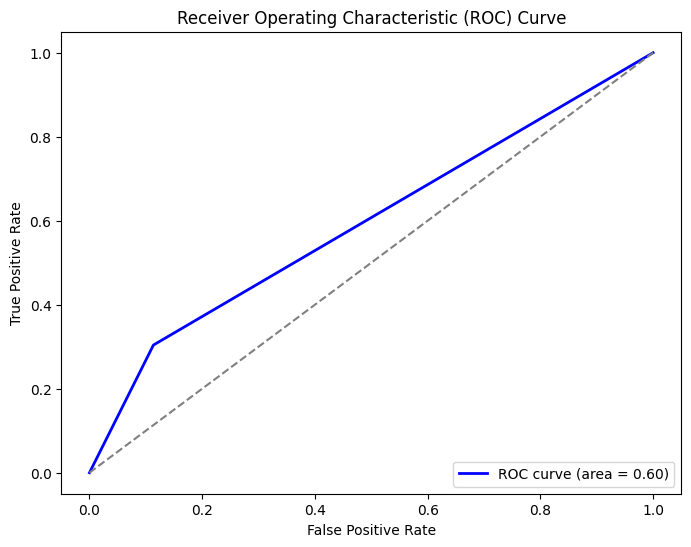

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming y_pred and y_test are available (y_pred should be continuous probability scores)
plot_roc_curve(y_test, y_pred)
